# PEPit : numerical examples of worst-case analyses

This notebook provides the source code for figures of [PEPit paper](https://arxiv.org/pdf/2201.04040.pdf). That is, it returns worst-case guarantee obtained with PEPit compared to its theoretical guarantee for **gradient descent** with fixed step size in contraction, the **accelerated gradient** method for strongly convex objectives, an **accelerated Douglas Rachford** splitting and **Point SAGA**.

PEPit can be installed following these $\href{https://pypi.org/project/PEPit/}{instructions}$, and a quickstart is available in its $\href{https://pepit.readthedocs.io/en/latest/}{documentation}$.

In [ ]:
# If PEPit is not installed yet, you can run this cell.
!pip install pepit

### List of examples

* [Example 1 : Gradient descent with fixed step size in contraction](#example1)
    * [1.1 Worst-case guarantee as a function of the iteration count](#section_1_1)
    * [1.2 Worst-case guarantee as a function of the step size](#section_1_2)
* [Example 2 : Accelerated gradient method for strongly convex objective](#example2)
* [Example 3 : Accelerated Douglas Rachford Splitting](#example3)
* [Example 4 : Point SAGA](#example4)

Let us first do the right imports, including python common packages (numpy, matplotlib) and PEPit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PEPit

# import gradient descent in contraction from the toolbox
from PEPit.examples.tutorials import wc_gradient_descent_contraction
# import from the toolbox the accelerated gradient method in the strongly convex setting
from PEPit.examples.unconstrained_convex_minimization import wc_accelerated_gradient_strongly_convex
# import accelerated Douglas Rachford Splitting from the toolbox
from PEPit.examples.composite_convex_minimization import wc_accelerated_douglas_rachford_splitting
# import Point SAGA from the toolbox
from PEPit.examples.stochastic_convex_minimization import wc_point_saga

In [2]:
# Set the verbose parameter to False to return worst-case without printing a detailed report.
verbose = False

## Example 1 : Gradient descent with fixed step size in contraction<a class="anchor" id="example1"></a>

The following convex minimization problem is considered
\begin{equation}
f_\star \triangleq \min_x f(x),
\end{equation}
where $f$ is $L$-smooth and $\mu$-strongly convex.

The package PEPit allows to compute a worst-case guarantee for **gradient descent** with fixed step size $\gamma$. That is, it computes the smallest possible $\tau(n, L, \mu, \gamma)$ such that the following guarantee holds
\begin{equation}
\| x_n - y_n \|^2 \leqslant \tau(n, L, \mu, \gamma) \| x_0 - y_0 \|^2,
\end{equation}
where $x_n$and $y_n$ are the outputs of the gradient descent with fixed step size $\gamma$, starting respectively from $x_0$ and $y_0$.

#### Algorithm

Gradient descent with fixed step size $\gamma$may be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
x_{t+1} = x_t - \gamma \nabla f(x_t).
\end{equation}

#### Theoretical guarantee

The **tight** theoretical guarantee is 
\begin{equation}
\| x_n - y_n \|^2 \leqslant \max\left\{(1-L\gamma)^2,(1-\mu \gamma)^2\right\}^n\| x_0 - y_0 \|^2,
\end{equation}
which is tight on simple quadratic functions.

### 1.1 Worst-case guarantee as a function of the iteration count <a class="anchor" id="section_1_1"></a>

In [3]:
# Set the parameters

L = 1          # smoothness parameter
mu = 0.1       # strong-convexity parameter
gamma = 1 / L  # step size

# Set a list of iteration counter to test
n_list = np.array([1, 2, 4, 6, 8, 10, 15])


# Compute worst-case and theoretical guarantee for each iteration count
pepit_taus = list()
theoretical_taus = list()
for n in n_list:
    pepit_tau, theoretical_tau = wc_gradient_descent_contraction(mu=mu,
                                                                 L=L,
                                                                 gamma=gamma,
                                                                 n=n,
                                                                 verbose=verbose,
                                                                )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

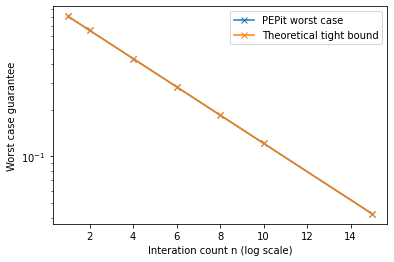

In [4]:
# Plot theoretical and PEPit worst-case performance as a function of the iteration count

plt.plot(n_list, pepit_taus, label='PEPit worst case', marker='x')
plt.plot(n_list, theoretical_taus, label='Theoretical tight bound', marker='x')

plt.semilogy()
plt.legend()
plt.xlabel('Interation count n (log scale)')
plt.ylabel('Worst case guarantee')

plt.show()

### 1.2 Worst-case guarantee as a function of the step size <a class="anchor" id="section_1_2"></a>

In [5]:
# Set the parameters
n = 1      # iteration counter
L = 1      # smoothness parameter
mu = 0.1   # strong-convexity parameter

# Set a list of step sizes to test
gammas = np.linspace(0, 2 / L, 41)

# Compute worst-case and theoretical guarantee for step size
pepit_taus = list()
theoretical_taus = list()
for gamma in gammas:
    pepit_tau, theoretical_tau = wc_gradient_descent_contraction(mu=mu,
                                                                 L=L,
                                                                 gamma=gamma,
                                                                 n=n,
                                                                 verbose=verbose,
                                                                )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

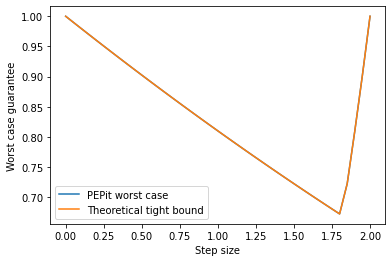

In [6]:
# Plot theoretical and PEPit worst-case performance as a function of the step size

plt.plot(gammas, pepit_taus, label='PEPit worst case')
plt.plot(gammas, theoretical_taus, label='Theoretical tight bound')

plt.legend()
plt.xlabel('Step size')
plt.ylabel('Worst case guarantee')

plt.show()

## Example 2 : Accelerated gradient method for strongly convex objective<a class="anchor" id="example2"></a>

The following convex minimization problem is considered
\begin{equation}
f_\star \triangleq \min_x f(x),
\end{equation}
where $f$ is $L$-smooth and $\mu$-strongly convex.


The package PEPit allows to compute a worst-case guarantee for the **accelerated gradient** method a.k.a **fast gradient** method. That is, it computes the smallest possible $\tau(n, L, \mu)$ such that the following guarantee holds
\begin{equation}
f(x_n) - f_\star \leqslant \tau(n, L, \mu) \left(F(x_0) - F_\star + \frac{\mu}{2}\| x_0 - x_\star\|^2_2\right),
\end{equation}
where $x_n$ is the output of the accelerated gradient method, and where $x_\star$ is the minimizer of $f$.


#### Algorithm

The accelerated gradient method may be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
\begin{aligned}
        x_{t+1} & = y_t - \alpha \nabla F(y_t),\\
        y_{t+1} & = x_{t+1} + \beta (x_{t+1} - x_{t}),
    \end{aligned}
\end{equation}
with $\kappa = \frac{\mu}{L}$, $\alpha = \frac{1}{L}$ and $\beta = \frac{1 - \sqrt{\kappa}}{1 + \sqrt{\kappa}}$.

#### Theoretical guarantee

A following **upper** theoretical guarantee is 
\begin{equation}
F(x_n) - F_\star \leqslant \tau(n, L, \mu) \left(F(x_0) -  F(x_\star) + \frac{\mu}{2}\|x_0 - x_\star\|^2_2\right).
\end{equation}

#### Plot worst-case guarantee as a function of the iteration count

In [7]:
# Set the parameters

L = 1          # smoothness parameter
mu = 0.1       # strong-convexity parameter
gamma = 1 / L  # step size

# Set a list of iteration counter to test
n_list = np.array([1, 2, 4, 6, 8, 10, 15])


# Compute worst-case and theoretical guarantee for each iteration count
pepit_taus = list()
theoretical_taus = list()
for n in n_list:
    pepit_tau, theoretical_tau = wc_accelerated_gradient_strongly_convex(mu=mu,
                                                                         L=L,
                                                                         n=n,
                                                                         verbose=verbose,
                                                                        )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

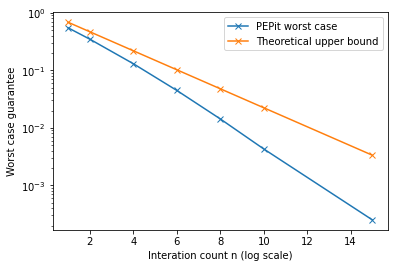

In [8]:
# Plot theoretical and PEPit worst-case performance as a function of the iteration count
plt.plot(n_list, pepit_taus, label='PEPit worst case', marker='x')
plt.plot(n_list, theoretical_taus, label='Theoretical upper bound', marker='x')

plt.semilogy()
plt.legend()
plt.xlabel('Interation count n (log scale)')
plt.ylabel('Worst case guarantee')

plt.show()

## Example 3 : Accelerated Douglas Rachford Splitting<a class="anchor" id="example3"></a>

The following composite convex minimization problem is considered
\begin{equation}
    F_\star \triangleq \min_x \{F(x) \equiv f_1(x) + f_2(x)\},
\end{equation}
where $f_1$ is closed proper and convex, and $f_2$ is $\mu$-strongly convex and $L$-smooth.

The package PEPit allows to compute a worst-case guarantee for **accelerated Douglas Rachford**. That is, it computes the smallest possible $\tau(n, L, \mu, \alpha)$ such that the following guarantee holds
\begin{equation}
F(y_n) - F(x_\star) \leqslant \tau(n, L, \mu, \alpha) \| w_0 - w_\star \|^2,
\end{equation}
where $\alpha$ is a parameter of the method, and where $y_n$ is the output of the accelerated Douglas Rachford Splitting method, where $x_\star$ is a minimizer of $F$, and $w_\star$ defined such that
\begin{equation}
x_\star = \text{prox}_{\alpha f_2}(w_\star)
\end{equation}
is an optimal point.

#### Algorithm

Accelerated Douglas Rachford Splitting may be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
    \begin{aligned}
        x_t     &= \mathrm{prox}_{\alpha f_2}(u_t), \\
        y_t     &= \mathrm{prox}_{\alpha f_1}(2x_t - u_t), \\
        w_{t+1} &= u_t +\theta (y_t - x_t), \\
        u_{t+1} &= \left\{\begin{array}{ll} w_{t+1}+\frac{t-1}{t+2}(w_{t+1}-w_t)\, & \mbox{if } t \geqslant 1,\\
                w_{t+1} & \mbox{otherwise,} \end{array} \right.
    \end{aligned}
\end{equation}

#### Theoretical guarantee

There is no theoretical guarantee for this method beyond quadratic minimization. For quadratics, an **upper** bound is 
\begin{equation}
    F(y_n) - F_\star \leqslant  \frac{2\|x_0 - w_\star\|^2_2}{\alpha \theta(n+3)^2},
\end{equation}
when $\theta = \frac{1 - \alpha L}{1 + \alpha L}$ and $\alpha < \frac{1}{L}$.

#### Plot worst-case guarantee as a function of the iteration count

In [9]:
# Set the parameters

L = 1          # smoothness parameter
mu = 0.1       # strong-convexity parameter
gamma = 1 / L  # step size
alpha = 0.9

# Set a list of iteration counter to test
n_list = np.array([1, 2, 4, 6, 8, 10, 15])


# Compute worst-case and theoretical guarantee for each iteration count
pepit_taus = list()
theoretical_taus = list()
for n in n_list:
    pepit_tau, theoretical_tau = wc_accelerated_douglas_rachford_splitting(mu=mu,
                                                                           L=L,
                                                                           alpha=alpha,
                                                                           n=n,
                                                                           verbose=verbose,
                                                                          )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

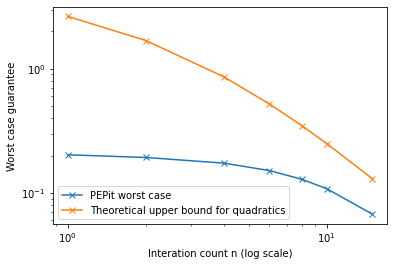

In [10]:
# Plot theoretical and PEPit worst-case performance as a function of the iteration count
plt.plot(n_list, pepit_taus, label='PEPit worst case', marker='x')
plt.plot(n_list, theoretical_taus, label='Theoretical upper bound for quadratics', marker='x')

plt.semilogy()
plt.semilogx()
plt.legend()
plt.xlabel('Interation count n (log scale)')
plt.ylabel('Worst case guarantee')

plt.show()

## Example 4 : Point SAGA<a class="anchor" id="example4"></a>

More precisely, the following finite sum minimization problem is considered
\begin{equation}
F_\star \triangleq \min_x \left\{F(x) \equiv \frac{1}{n} \sum_{i=1}^{n} f_i(x)\right\},
\end{equation}
where $f_1, \ldots, f_n$ are $L$-smooth and $\mu$-strongly convex functions with a proximal operator available for each of them.

The package PEPit allows to compute a tight (one-step) worst-case guarantee using a Lyapunov function for **Point SAGA**. The Lyapunov (or energy) function at a point $x$ is given by:
\begin{equation}
V(x) = \frac{1}{L \mu}\frac{1}{n} \sum_{i \leqslant n} \|\nabla f_i(x) - \nabla f_i(x_\star)\|^2_2 + \|x - x_\star\|^2_2,
\end{equation}
where $x_\star$ denotes the minimizer of $F$. The code computes the smallest possible $\tau(n, L, \mu)$ such that the guarantee (in expectation)
\begin{equation}
\mathbb{E}_{j_t}\Big[V\big(x^{(t+1)}_{j_t}\big)\Big] \leqslant \tau(n, L, \mu) V\left(x^{(t)}\right),
\end{equation}
is valid.

#### Algorithm

At each iteration $t$, Point SAGA picks $j_t \in \{1, \ldots, n\}$ uniformly at random and performs the following updates
\begin{equation*}
    \begin{aligned}
    z_{j_t}^{(t)} &= x^{(t)} + \gamma \left(g_{j_t}^{(t)} - \frac{1}{n} \sum_i g_i^{(t)}\right),\\
    x^{(t+1)}_{j_t} &= \mathrm{prox}_{\gamma f_{j_t}} \left(z_{j_t}^{(t)}\right),\\
    g_{j_t}^{(t+1)} &= \frac{1}{\gamma}\left(z_{j_t}^{(t)} - x^{(t+1)}_{j_t}\right),
    \end{aligned}
\end{equation*}
where $\gamma=\frac{\sqrt{(n - 1)^2 + 4n\frac{L}{\mu}}}{2Ln} - \frac{\left(1 - \frac{1}{n}\right)}{2L}$ is the step size.

#### Thoeretical guarantee

A theoretical **upper** bound is given by
\begin{equation}
\mathbb{E}_{j_t}\left[V\left(x^{(t+1)}_{j_t}\right)\right] \leqslant \frac{1}{1 + \mu\gamma} V\left(x^{(t)}\right).
\end{equation}

#### Plot worst-case guarantee as a function of the condition number

We have seen that the proof is based on a Lyapunov function, that is decreasing along the sequence at some rate. This allows to extend the convergence result to larger iteration counts, and thus to plot convergence as a function of the condition number $\kappa = \frac{L}{\mu}$.

In [11]:
# Set the parameters

L = 1         # smoothness parameter
n = 5         # the number of functions

# Set a list of strong convesity parameter to test, given that the condition number kappa = L / mu
mus = np.array([0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001])
    

# Compute worst-case and theoretical guarantee for each iteration count
pepit_taus = list()
theoretical_taus = list()
for mu in mus:
    pepit_tau, theoretical_tau = wc_point_saga(L=L,
                                               mu=mu,
                                               n=n,
                                               verbose=verbose,
                                              )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

/usr/local/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


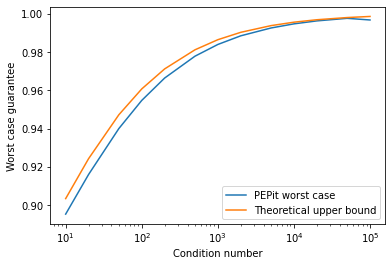

In [12]:
# Plot theoretical and PEPit worst-case performance as a function of the iteration count

plt.plot(L/mus, pepit_taus, label='PEPit worst case')
plt.plot(L/mus, theoretical_taus, label='Theoretical upper bound')

plt.semilogx()
plt.legend()
plt.xlabel('Condition number')
plt.ylabel('Worst case guarantee')

plt.show()